<a href="https://colab.research.google.com/github/isadays/Embeddings/blob/main/TestingEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We study the efficiency of embeddings. We have notice that the embeddings are high sensitive to the variance of the target variable (we did log transformation )

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score,classification_report,mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import ks_2samp
from scipy.cluster.hierarchy import dendrogram, linkage
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F



Dataset

In [9]:
class FlightDataset(Dataset):
    def __init__(self, df):
        self.cats = df[categorical_cols].values
        self.nums = df[numerical_cols].values.astype(np.float32)
        self.y = df[target_col].values.astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {
            'categorical': torch.tensor(self.cats[idx], dtype=torch.long),
            'numerical': torch.tensor(self.nums[idx], dtype=torch.float),
            'target': torch.tensor(self.y[idx], dtype=torch.float)
        }

Transformer Architecture

In [10]:
class FlightPriceMLP(nn.Module):
    def __init__(self, cat_cardinalities, embedding_dim=8, num_numerical=2):
        super().__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(card, embedding_dim) for card in cat_cardinalities
        ])

        input_dim = embedding_dim * len(cat_cardinalities) + num_numerical

        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

        for emb in self.embeddings:
            nn.init.xavier_uniform_(emb.weight.data)

    def forward(self, categorical, numerical):
        embedded = [emb(categorical[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(embedded + [numerical], dim=1)
        out = self.model(x)
        return out.squeeze()

In [2]:
df = pd.read_csv('Clean_Dataset.csv')

In [4]:
df = df.drop('Unnamed: 0', axis=1)

In [3]:
df['price'].describe()

,price
count,91554.000000
mean,6353.699161
std,3649.664108
min,1890.000000
25%,4020.000000
50%,5529.000000
75%,7487.000000
max,35145.000000


In [5]:
import numpy as np
df['log_price'] = np.log1p(df['price'])


In [6]:
df.columns

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price'],
      dtype='object')

In [6]:
df['log_price'].describe()

,log_price
count,91554.000000
mean,8.618595
std,0.518012
min,7.544861
25%,8.299286
50%,8.617943
75%,8.921057
max,10.467266


In [38]:
categorical_cols = ['airline', 'flight', 'source_city', 'departure_time',
                    'stops', 'arrival_time', 'destination_city', 'class']
numerical_cols = ['duration', 'days_left']
target_col = 'log_price'


In [39]:
label_encoders = {col: LabelEncoder().fit(df[col]) for col in categorical_cols}
for col in categorical_cols:
    df[col] = label_encoders[col].transform(df[col])

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])



In [40]:
dataset = FlightDataset(df)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [41]:
batch = next(iter(loader))

print("Categorical shape:", batch['categorical'].shape)
print("Numerical shape:", batch['numerical'].shape)
print("Target shape:", batch['target'].shape)

print("Categorical sample:", batch['categorical'][0])
print("Numerical sample:", batch['numerical'][0])
print("Target sample:", batch['target'][0])

Categorical shape: torch.Size([64, 8])
Numerical shape: torch.Size([64, 2])
Target shape: torch.Size([64])
Categorical sample: tensor([  5, 931,   1,   1,   0,   6,   1,   0])
Numerical sample: tensor([0.8501, 1.5215])
Target sample: tensor(8.5407)


In [42]:
class FlightPriceMLP(nn.Module):
    def __init__(self, cat_cardinalities, embedding_dim=8, num_numerical=2):
        super().__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(card, embedding_dim) for card in cat_cardinalities
        ])

        input_dim = embedding_dim * len(cat_cardinalities) + num_numerical

        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

        # Explicit Initialization
        for emb in self.embeddings:
            nn.init.xavier_uniform_(emb.weight.data)

    def forward(self, categorical, numerical):
        embedded = [emb(categorical[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(embedded + [numerical], dim=1)
        out = self.model(x)
        return out.squeeze()


In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FlightPriceMLP(cat_cardinalities, embedding_dim=8, num_numerical=len(numerical_cols)).to(device)


In [44]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch in loader:
        categorical = batch['categorical'].to(device)
        numerical = batch['numerical'].to(device)
        target = batch['target'].to(device)

        optimizer.zero_grad()
        outputs = model(categorical, numerical)
        loss = criterion(outputs, target)

        if torch.isnan(loss):
            print("NaN loss detected! This should NOT happen now.")
            break

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')




NaN loss detected! This should NOT happen now.
Epoch 1/20, Loss: 9.8591
NaN loss detected! This should NOT happen now.
Epoch 2/20, Loss: 0.4622
NaN loss detected! This should NOT happen now.
Epoch 3/20, Loss: 0.2078
NaN loss detected! This should NOT happen now.
Epoch 4/20, Loss: 0.3558
NaN loss detected! This should NOT happen now.
Epoch 5/20, Loss: 0.3713
NaN loss detected! This should NOT happen now.
Epoch 6/20, Loss: 0.6812
NaN loss detected! This should NOT happen now.
Epoch 7/20, Loss: 0.0594
NaN loss detected! This should NOT happen now.
Epoch 8/20, Loss: 0.4247
NaN loss detected! This should NOT happen now.
Epoch 9/20, Loss: 0.2148
NaN loss detected! This should NOT happen now.
Epoch 10/20, Loss: 0.4772
NaN loss detected! This should NOT happen now.
Epoch 11/20, Loss: 0.0059
NaN loss detected! This should NOT happen now.
Epoch 12/20, Loss: 0.4344
NaN loss detected! This should NOT happen now.
Epoch 13/20, Loss: 0.0764
NaN loss detected! This should NOT happen now.
Epoch 14/20, 

In [45]:
model.eval()
with torch.no_grad():
    batch = next(iter(loader))
    preds = model(batch['categorical'].to(device), batch['numerical'].to(device))

preds_original_scale = np.expm1(preds.cpu().numpy())
print("Predictions (original scale):", preds_original_scale[:10])



Predictions (original scale): [ 2848.1753  3812.2488 10884.521   4698.1245  2917.4417  4012.9082
  3775.0615  4422.134   5003.707   7046.343 ]


In [46]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in loader:
        categorical = batch['categorical'].to(device)
        numerical = batch['numerical'].to(device)
        target = batch['target'].cpu().numpy()

        preds = model(categorical, numerical).cpu().numpy()

        all_preds.extend(preds)
        all_targets.extend(target)

# Convert back to original scale explicitly
all_preds_original = np.expm1(all_preds)
all_targets_original = np.expm1(all_targets)


In [47]:
print("NaNs in Predictions:", np.isnan(all_preds_original).sum())
print("NaNs in Targets:", np.isnan(all_targets_original).sum())


NaNs in Predictions: 1
NaNs in Targets: 1


In [48]:
all_preds_original = np.nan_to_num(all_preds_original, nan=np.nanmedian(all_preds_original))
all_targets_original = np.nan_to_num(all_targets_original, nan=np.nanmedian(all_targets_original))


In [49]:
mask = ~np.isnan(all_preds_original) & ~np.isnan(all_targets_original)
all_preds_original = np.array(all_preds_original)[mask]
all_targets_original = np.array(all_targets_original)[mask]


In [50]:
mae = mean_absolute_error(all_targets_original, all_preds_original)
mse = mean_squared_error(all_targets_original, all_preds_original)
rmse = np.sqrt(mse)
r2 = r2_score(all_targets_original, all_preds_original)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 1314.66
Mean Squared Error (MSE): 4485089.00
Root Mean Squared Error (RMSE): 2117.80
R-squared (R²): 0.6633


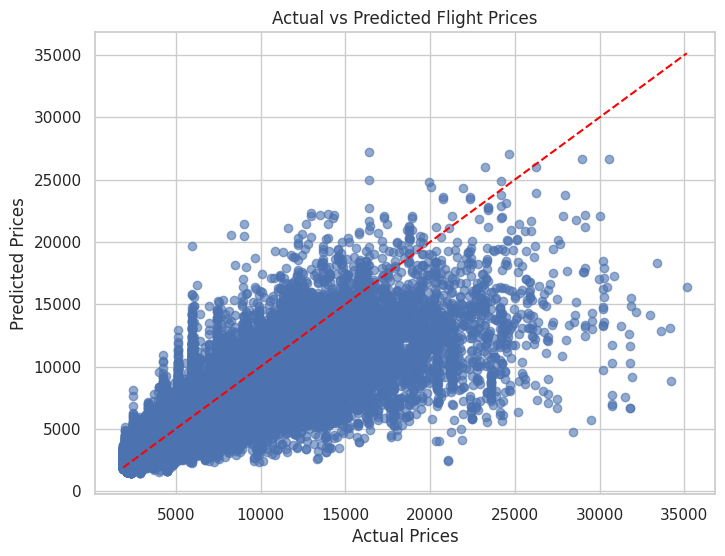

In [51]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.scatter(all_targets_original, all_preds_original, alpha=0.6)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Flight Prices")
plt.plot([min(all_targets_original), max(all_targets_original)],
         [min(all_targets_original), max(all_targets_original)],
         color='red', linestyle='--')
plt.show()


In [52]:
threshold = np.median(all_targets_original)
binary_true = (all_targets_original > threshold).astype(int)
binary_preds = (all_preds_original > threshold).astype(int)


In [53]:
print("Classification Report:\n")
print(classification_report(binary_true, binary_preds))


Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.91      0.82     45778
           1       0.89      0.70      0.78     45777

    accuracy                           0.80     91555
   macro avg       0.82      0.80      0.80     91555
weighted avg       0.82      0.80      0.80     91555



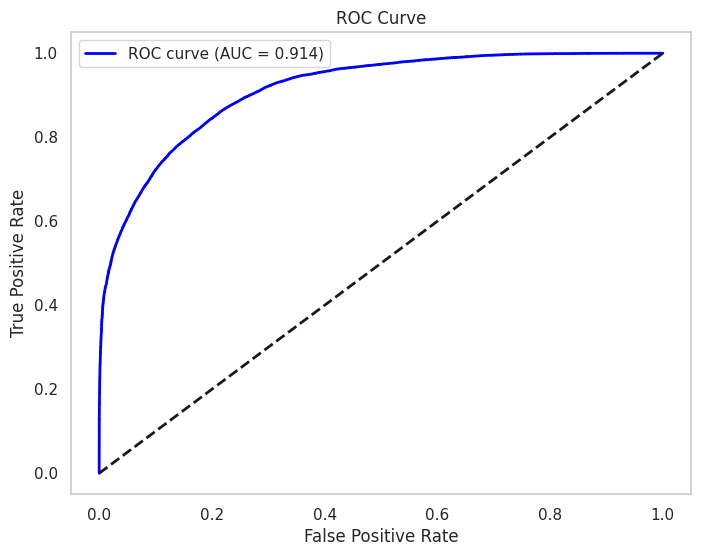

In [54]:
fpr, tpr, _ = roc_curve(binary_true, all_preds_original)
auc_score = roc_auc_score(binary_true, all_preds_original)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


In [55]:
preds_high = all_preds_original[binary_true == 1]
preds_low = all_preds_original[binary_true == 0]

ks_stat, ks_pvalue = ks_2samp(preds_high, preds_low)

print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_pvalue:.4e}")


KS Statistic: 0.6461, p-value: 0.0000e+00


Improving the models performance by doing feature engineering

In [3]:
df = pd.read_csv('Clean_Dataset.csv')

In [4]:
df = df.drop('Unnamed: 0', axis=1)

In [5]:
df['is_night'] = df['departure_time'].apply(lambda x: 1 if 'Night' in x else 0)
df['is_evening'] = df['departure_time'].apply(lambda x: 1 if 'Evening' in x else 0)
df['is_morning'] = df['departure_time'].apply(lambda x: 1 if 'Morning' in x else 0)
df['is_afternoon'] = df['departure_time'].apply(lambda x: 1 if 'Afternoon' in x else 0)


In [6]:
df['log_price'] = np.log1p(df['price'])

In [58]:
categorical_cols = [
    'airline', 'flight', 'source_city', 'departure_time',
    'stops', 'arrival_time', 'destination_city', 'class',
    'is_night', 'is_evening', 'is_morning', 'is_afternoon'
]
numerical_cols = ['duration', 'days_left']
target_col = 'log_price'

label_encoders = {col: LabelEncoder().fit(df[col]) for col in categorical_cols}
for col in categorical_cols:
    df[col] = label_encoders[col].transform(df[col])

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])



In [59]:
cat_cardinalities = [df[col].nunique() for col in categorical_cols]

dataset = FlightDataset(df)
loader = DataLoader(dataset, batch_size=64, shuffle=True)


In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FlightPriceMLP(cat_cardinalities, embedding_dim=8, num_numerical=len(numerical_cols)).to(device)

In [61]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch in loader:
        categorical = batch['categorical'].to(device)
        numerical = batch['numerical'].to(device)
        target = batch['target'].to(device)

        optimizer.zero_grad()
        outputs = model(categorical, numerical)
        loss = criterion(outputs, target)

        if torch.isnan(loss):
            print("NaN loss detected! This should NOT happen now.")
            break

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

Epoch 1/20, Loss: 3.8051
Epoch 2/20, Loss: 0.7773
Epoch 3/20, Loss: 0.7051
Epoch 4/20, Loss: 0.6404
Epoch 5/20, Loss: 0.5810
Epoch 6/20, Loss: 0.5259
Epoch 7/20, Loss: 0.4735
Epoch 8/20, Loss: 0.4256
Epoch 9/20, Loss: 0.3850
Epoch 10/20, Loss: 0.3501
Epoch 11/20, Loss: 0.3198
Epoch 12/20, Loss: 0.2905
Epoch 13/20, Loss: 0.2706
Epoch 14/20, Loss: 0.2512
Epoch 15/20, Loss: 0.2314
Epoch 16/20, Loss: 0.2134
Epoch 17/20, Loss: 0.1980
Epoch 18/20, Loss: 0.1815
Epoch 19/20, Loss: 0.1683
Epoch 20/20, Loss: 0.1546


In [62]:
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for batch in loader:
        categorical = batch['categorical'].to(device)
        numerical = batch['numerical'].to(device)
        target = batch['target'].cpu().numpy()

        preds = model(categorical, numerical).cpu().numpy()

        all_preds.extend(preds)
        all_targets.extend(target)






In [63]:
all_preds_original = np.expm1(all_preds)
all_targets_original = np.expm1(all_targets)

In [64]:
mask = ~np.isnan(all_preds_original) & ~np.isnan(all_targets_original)
all_preds_original = np.array(all_preds_original)[mask]
all_targets_original = np.array(all_targets_original)[mask]


In [65]:
mae = mean_absolute_error(all_targets_original, all_preds_original)
rmse = np.sqrt(mean_squared_error(all_targets_original, all_preds_original))
r2 = r2_score(all_targets_original, all_preds_original)

print(f"Improved MAE: {mae:.2f}")
print(f"Improved RMSE: {rmse:.2f}")
print(f"Improved R²: {r2:.4f}")

Improved MAE: 2253.96
Improved RMSE: 4333.17
Improved R²: 0.9636


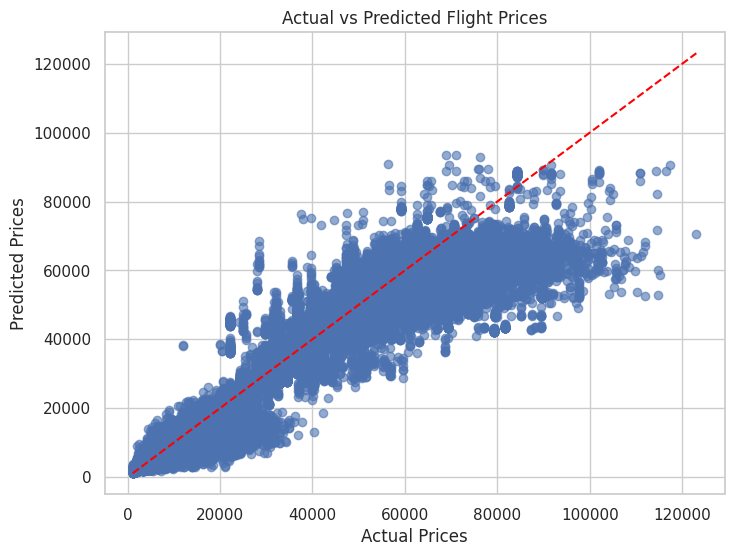

In [66]:

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.scatter(all_targets_original, all_preds_original, alpha=0.6)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Flight Prices")
plt.plot([min(all_targets_original), max(all_targets_original)],
         [min(all_targets_original), max(all_targets_original)],
         color='red', linestyle='--')
plt.show()


We transform our results into binary classification (by setting a threshold ) to avaliate other performance metrics - note that it is just a curious fact - these measures do not give us precise information

In [67]:
threshold = np.median(all_targets_original)
binary_true = (all_targets_original > threshold).astype(int)
binary_preds = (all_preds_original > threshold).astype(int)


In [68]:
print("Classification Report:\n")
print(classification_report(binary_true, binary_preds))


Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.96      0.94    150190
           1       0.96      0.91      0.93    149963

    accuracy                           0.93    300153
   macro avg       0.94      0.93      0.93    300153
weighted avg       0.94      0.93      0.93    300153



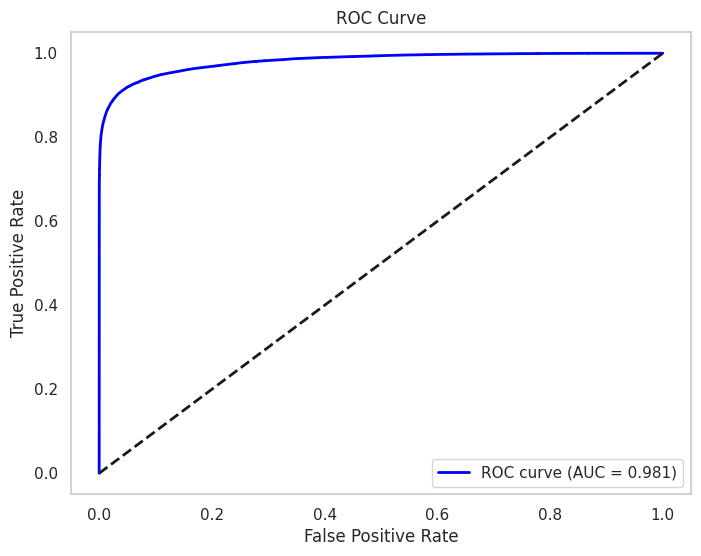

In [69]:
fpr, tpr, _ = roc_curve(binary_true, all_preds_original)
auc_score = roc_auc_score(binary_true, all_preds_original)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


In [70]:

preds_high = all_preds_original[binary_true == 1]
preds_low = all_preds_original[binary_true == 0]

ks_stat, ks_pvalue = ks_2samp(preds_high, preds_low)

print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_pvalue:.4e}")


KS Statistic: 0.8701, p-value: 0.0000e+00


Visualizing the embeddings

In [71]:
airline_idx = categorical_cols.index('airline')
airline_embedding_weights = model.embeddings[airline_idx].weight.detach().cpu().numpy()

print("Airline embeddings shape:", airline_embedding_weights.shape)


Airline embeddings shape: (6, 8)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


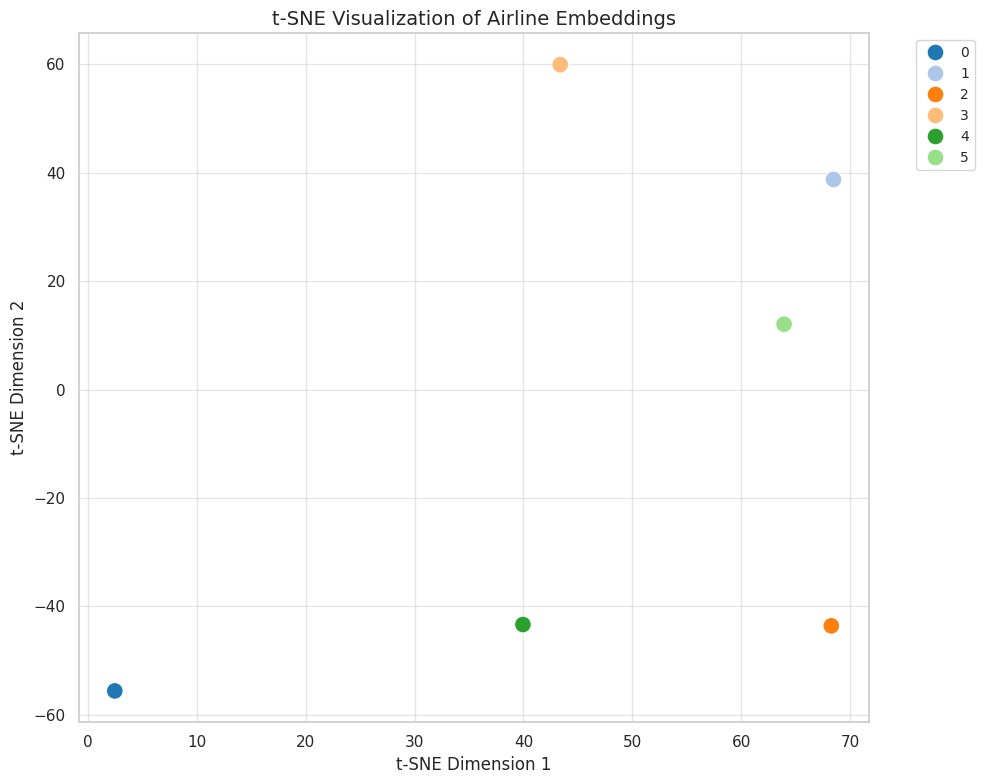

In [72]:

tsne = TSNE(n_components=2, random_state=42, perplexity=2, n_iter=1000)
airline_embedded_2d = tsne.fit_transform(airline_embedding_weights)

airline_labels = label_encoders['airline'].inverse_transform(np.arange(airline_embedding_weights.shape[0]))

df_tsne_airline = pd.DataFrame({
    'tsne_1': airline_embedded_2d[:, 0],
    'tsne_2': airline_embedded_2d[:, 1],
    'airline': airline_labels
})

plt.figure(figsize=(10,8))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    data=df_tsne_airline,
    hue='airline',
    palette='tab20',
    s=150
)
plt.title('t-SNE Visualization of Airline Embeddings', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()


In [73]:
def plot_tsne_embedding(embedding_weights, labels, title, perplexity=2):
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=1000)
    embedded_2d = tsne.fit_transform(embedding_weights)

    df_tsne = pd.DataFrame({
        'tsne_1': embedded_2d[:, 0],
        'tsne_2': embedded_2d[:, 1],
        'label': labels
    })

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='tsne_1', y='tsne_2',
        data=df_tsne,
        hue='label',
        palette='tab20',
        s=200,
        legend=False
    )


    for i in range(df_tsne.shape[0]):
        plt.text(df_tsne['tsne_1'][i]+0.01, df_tsne['tsne_2'][i]+0.01,
                 df_tsne['label'][i], fontsize=10)

    plt.title(f't-SNE of {title}', fontsize=16)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(alpha=0.5)


    plt.show()


In [74]:
source_idx = categorical_cols.index('source_city')
source_embedding_weights = model.embeddings[source_idx].weight.detach().cpu().numpy()
source_labels = label_encoders['source_city'].inverse_transform(np.arange(source_embedding_weights.shape[0]))

print("Source city embeddings shape:", source_embedding_weights.shape)


Source city embeddings shape: (6, 8)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


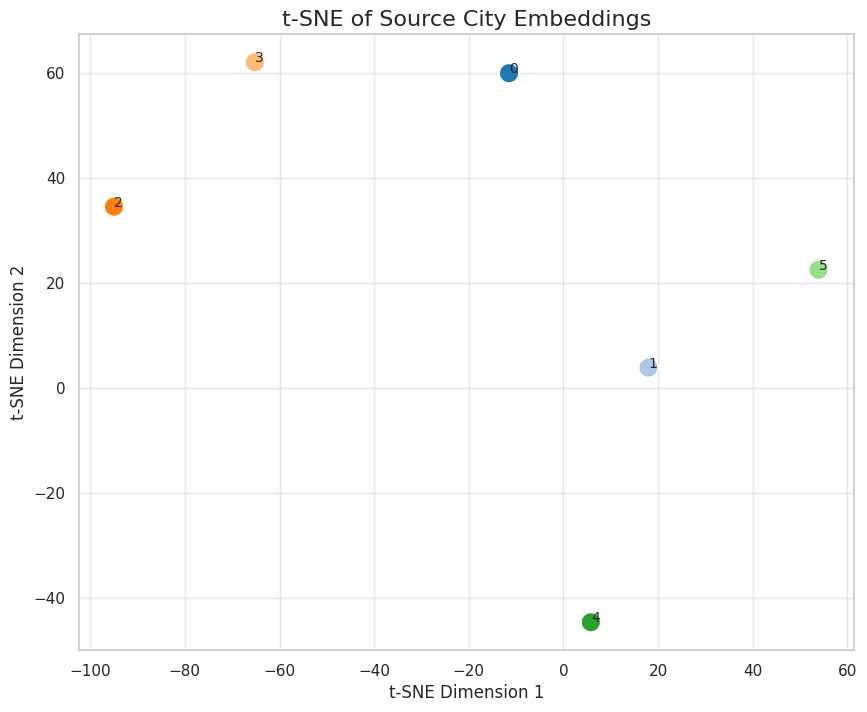

In [75]:
plot_tsne_embedding(source_embedding_weights, source_labels, title='Source City Embeddings', perplexity=3)


In [76]:
class_idx = categorical_cols.index('class')
class_embedding_weights = model.embeddings[class_idx].weight.detach().cpu().numpy()
class_labels = label_encoders['class'].inverse_transform(np.arange(class_embedding_weights.shape[0]))

print("Class embeddings shape:", class_embedding_weights.shape)


Class embeddings shape: (2, 8)


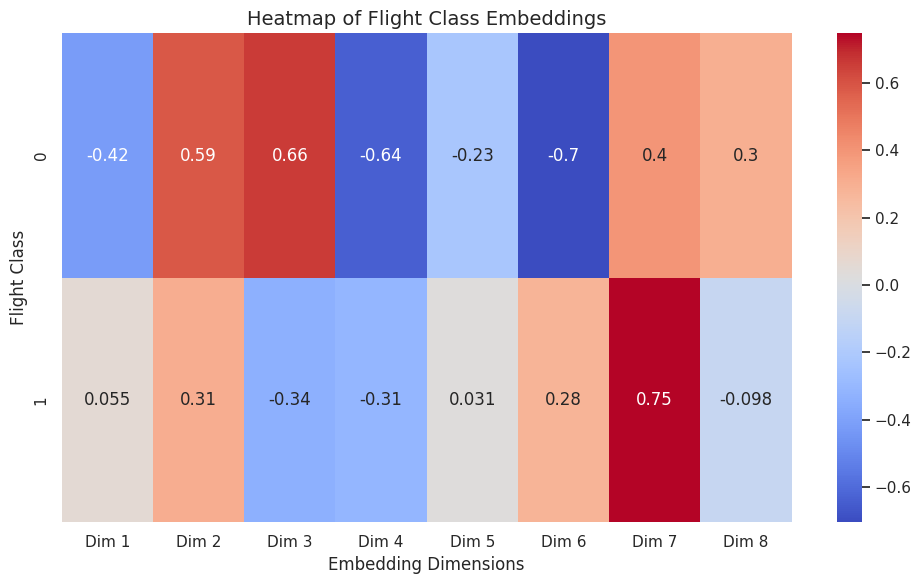

In [77]:
plt.figure(figsize=(10, 6))
sns.heatmap(class_embedding_weights, annot=True, cmap='coolwarm', xticklabels=[f'Dim {i+1}' for i in range(class_embedding_weights.shape[1])], yticklabels=class_labels)

plt.title('Heatmap of Flight Class Embeddings', fontsize=14)
plt.xlabel('Embedding Dimensions')
plt.ylabel('Flight Class')
plt.tight_layout()
plt.show()


In [79]:
def plot_pca_embeddings(embedding_weights, labels, title):
    pca = PCA(n_components=2)
    embedding_pca = pca.fit_transform(embedding_weights)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x=embedding_pca[:, 0], y=embedding_pca[:, 1],
        hue=labels,
        palette='tab10',
        s=200
    )

    for i, label in enumerate(labels):
        plt.text(embedding_pca[i, 0]+0.02, embedding_pca[i, 1]+0.02, label, fontsize=12, weight='bold')

    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'PCA Visualization of {title}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

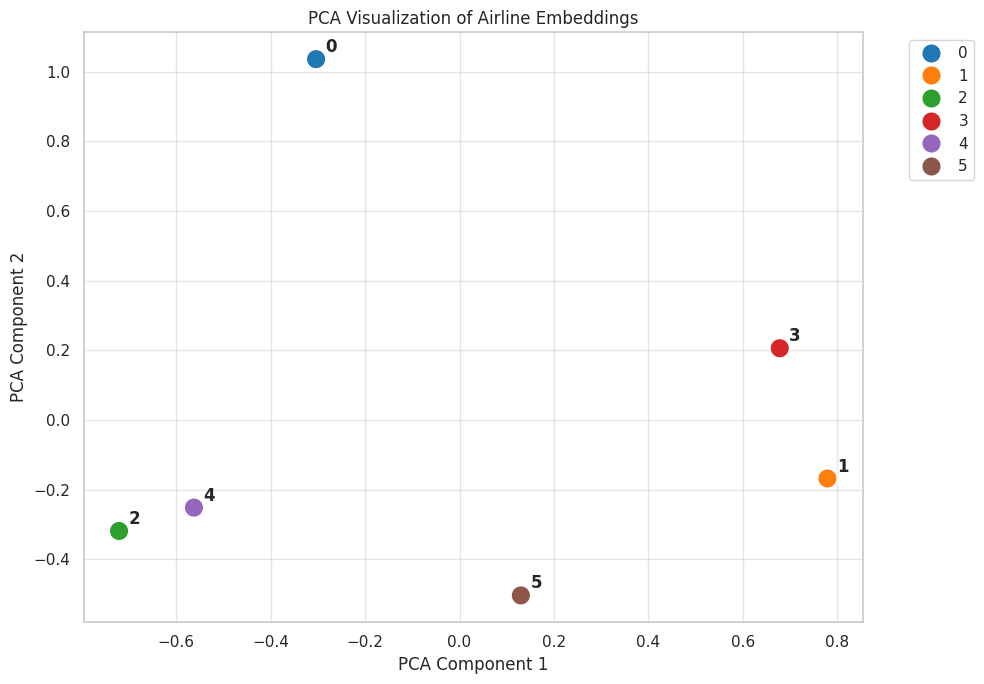

In [80]:
plot_pca_embeddings(airline_embedding_weights, airline_labels, 'Airline Embeddings')


In [85]:
def plot_cosine_similarity_heatmap(embedding_weights, labels, title):
    similarity_matrix = cosine_similarity(embedding_weights)

    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, annot=True, fmt=".2f",
                xticklabels=labels, yticklabels=labels, cmap='coolwarm')

    plt.title(f'Pairwise Cosine Similarity of {title}', fontsize=14)
    plt.xlabel('Categories')
    plt.ylabel('Categories')
    plt.tight_layout()
    plt.show()

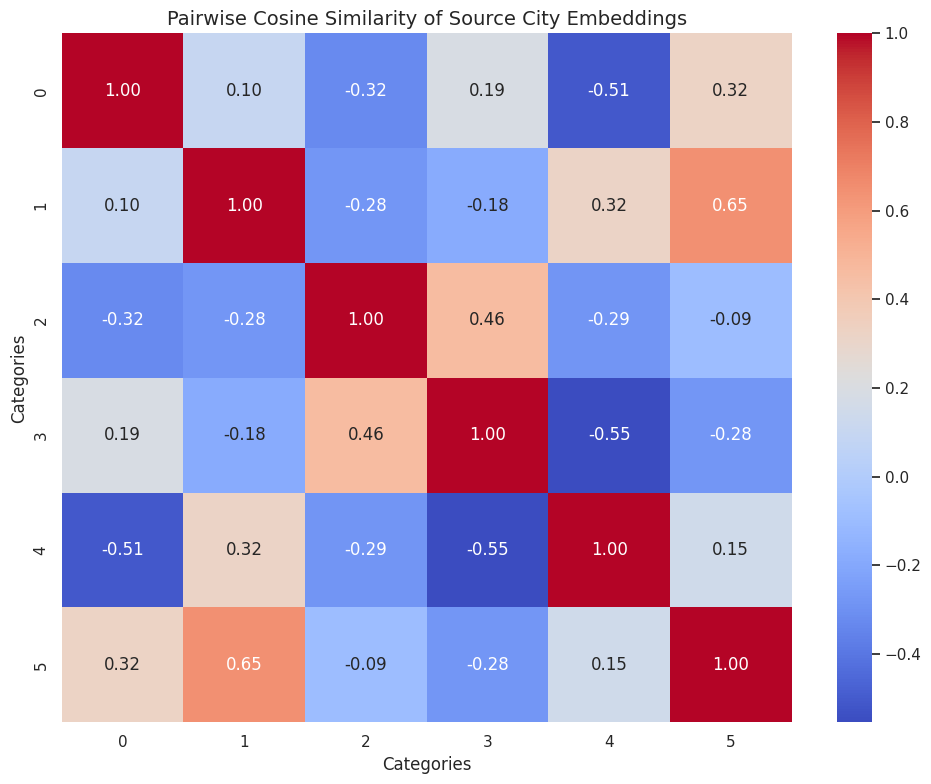

In [86]:
plot_cosine_similarity_heatmap(source_embedding_weights, source_labels, 'Source City Embeddings')


In [87]:
def plot_embedding_dendrogram(embedding_weights, labels, title):
    linked = linkage(embedding_weights, method='ward')

    plt.figure(figsize=(10, 6))
    dendrogram(linked,
               orientation='top',
               labels=labels,
               distance_sort='descending',
               show_leaf_counts=True)

    plt.title(f'Dendrogram of {title}', fontsize=14)
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.show()

In [97]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

def plot_embedding_dendrogram(embedding_weights, labels, title):
    linked = linkage(embedding_weights, method='ward')

    plt.figure(figsize=(12, 8))
    dendrogram(linked,
               orientation='top',
               labels=labels,
               distance_sort='descending',
               leaf_rotation=45,  # rotates labels for better readability
               leaf_font_size=12, # increases readability
               show_leaf_counts=True)

    plt.title(f'Dendrogram of {title}', fontsize=16, fontweight='bold')
    plt.ylabel('Hierarchical Distance')
    plt.tight_layout()
    plt.show()


In [98]:
dest_idx = categorical_cols.index('destination_city')
dest_embedding_weights = model.embeddings[dest_idx].weight.detach().cpu().numpy()

dest_labels = label_encoders['destination_city'].inverse_transform(
    np.arange(dest_embedding_weights.shape[0])
)

print("Destination labels decoded:", dest_labels)


Destination labels clearly decoded: [0 1 2 3 4 5]


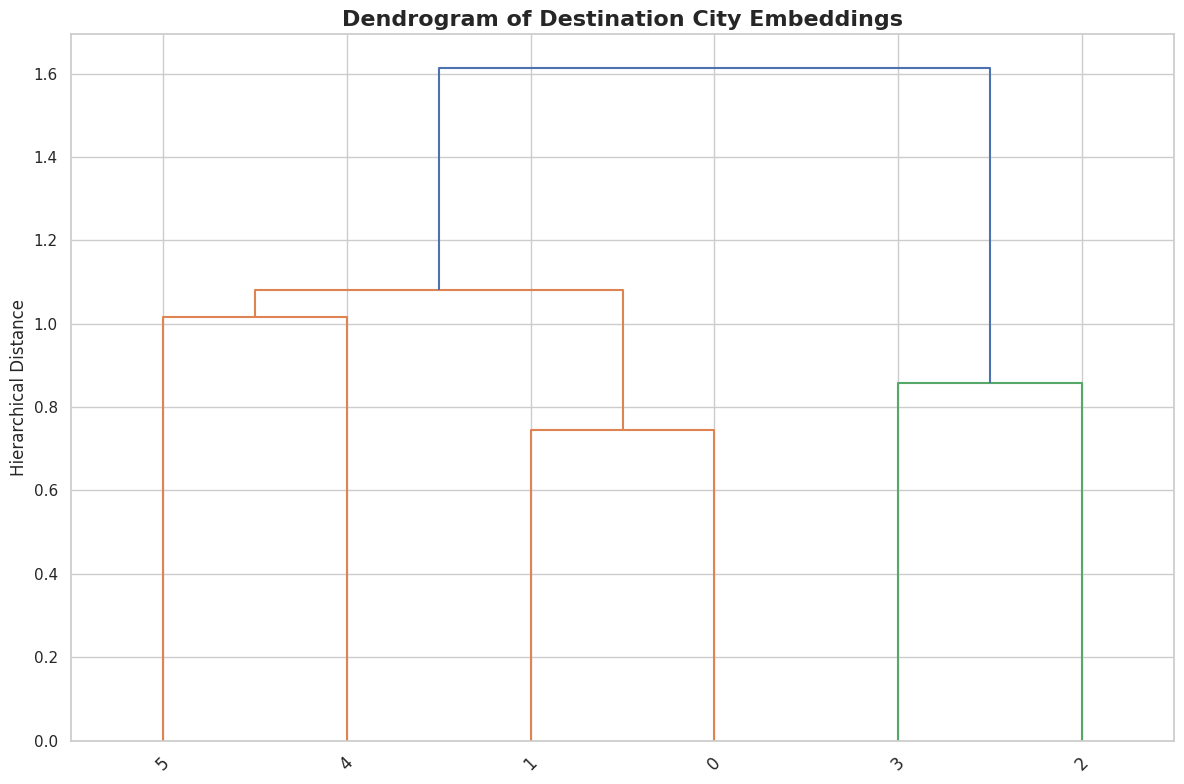

In [99]:
plot_embedding_dendrogram(dest_embedding_weights, dest_labels, 'Destination City Embeddings')
